In [1]:
from fz_text_seg import tokenization, lexical_score, find_boundaries, create_blocks
import matplotlib.pyplot as plt
import numpy as np

## TEXTTILING
Per l'esercizio è stato sviluppato il codice per l'algoritmo seguendo l'articolo che lo descrive.
L'algoritmo si compone quindi di tre fasi:
1. Tokenizazion, prende un testo e lo trasforma in sequenze di token di dimensione $w$
2. Lexical score, fatto tramite lo score di similarità intra-blocchi dove ogni blocco ha $k$ sequenze di token
3. Bounderies identification

Qui sotto sono definite come variabili globali la dimensione $w$ per una sequenza di token e la dmensione $k$ per un blocco

In [2]:
w_token = 20
k_block = 4

### Tokenization
In questa prima fase viene preso un testo, viene pulito (eliminazione di punteggiatura e numeri) e viene poi **tokenizzato**. Dalla lista di token vengono create le **sequenze di token** che contengono $w_token$ elementi. Dopo di che, queste sequenze vengono pulite dalle **stop words** e **stemmatizzati** i token rimanenti.
Viene restituita la lista delle sequenze di token e una lista con le parole stemmatizzate e pulite, questa seconda lista servirà più avanti per calcolare la similirità tra blocchi.
Qui finisce la prima fase.

In [3]:
text_tokens, unique_tokens = tokenization('corpus.txt', w_token)

In [4]:
print('Numero sequenze di token:', len(text_tokens))

Numero sequenze di token: 90


### Lexical score
Da qui entriamo nella seconda fase, che è quella del *lexical score*.

A questo punto vengono creati i blocchi date le sequenze di token e la variabile $k\ block$. Il metodo restituisce una lista di blocchi (ogni blocco è una lista di sequenze di token) e la lista con i tagli che ci si aspetta vengano fatti. Infatti nel corpus fornito è presente un token inventato che serve per segnare la fine di un paragrafo, questo permette di avere una stima di bontà del risultato dell'algoritmo.

In [5]:
blocks, paragraphs = create_blocks(text_tokens, k_block)
print('Numero sequenze di blocchi:', len(blocks))

Numero sequenze di blocchi: 23


Arrivati qui vengono calcolati i lexical score tra i blocchi.
Dati due blocchi viene calcolato uno score tra il gap $i$ in base al conteggio delle parole che contengono questi blocchi, in particolare si usa la formula $score(i) =  \frac{\sum_t w_{t, b_1} * w_{t, b_2}} {sqrt{\sum_t w_{t, b_1}^2 * \sum_t w_{t, b_2}^2}}$. La formula restituisce un valore nell'intervallo $[0, 1]$ e viene eseguita sulla lista a coppie di blocchi.

Quando sono stati calcolati tutti gli score si esegue, più volte, una procedura di smoothing per rimuovere i gap più piccoli, che rischiano di alterare il risultato successivamente. Lo smoothing è stato fatto con una funzione di NumPy.

In [6]:
lex_score, lex_score_smooth = lexical_score(blocks, unique_tokens)

### Bounderies identification
Questo processo assegna a ogni gap uno score di profondità (**depth score**) che misura il cambio di argomento tra i due lati del gap dati i loro lexical score. In particolare la formula è $(y_a_{i-1} - y_a_{i}) + (y_a_{i+1} - y_a_{i})$.
L'algoritmo ordina la lista dei depth score in modo non crescente e restituisce gli $n$ valori in cima (che saranno quelli con i punteggi maggiori), dove $n$ è il numero di tagli previsti trovati nella creazione di blocchi.

In [7]:
depth_max_pts = find_boundaries(lex_score_smooth, len(paragraphs))

### Risultati
In questa cella viene stampato un grafico per la visualizzazione dei tagli da fare sul documento per dividerlo nei subtopic.

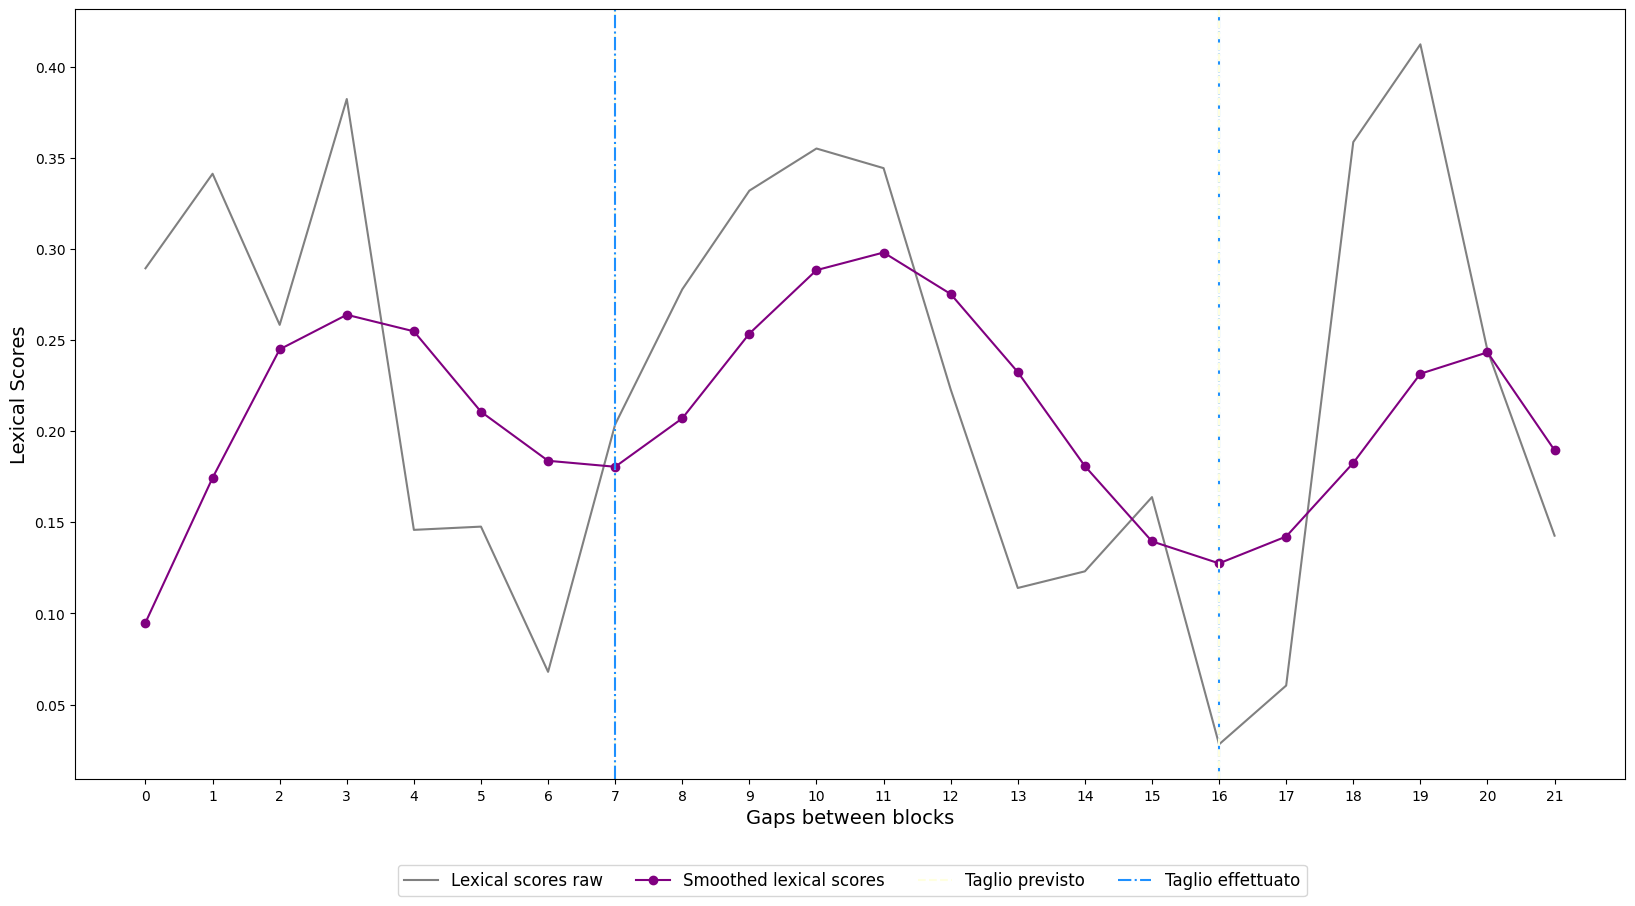

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.plot(np.arange(0, len(lex_score)), lex_score, '-', color='grey', label='Lexical scores raw')
ax.plot(np.arange(0, len(lex_score_smooth)), lex_score_smooth, '-o', color='purple', label='Smoothed lexical scores')
x = [point[1] for point in depth_max_pts]

ax.set_xticks(np.arange(0, len(lex_score)))
plt.xlabel('Gaps between blocks', fontsize=14)
plt.ylabel('Lexical Scores', fontsize=14)

for i in range(len(paragraphs)):
    plt.axvline(x=paragraphs[i], linestyle='dashed', color='lightyellow', label='Taglio previsto')
    plt.axvline(x=x[i], linestyle='dashdot', color='dodgerblue', label='Taglio effettuato')

ax.legend(['Lexical scores raw','Smoothed lexical scores','Taglio previsto', 'Taglio effettuato'], bbox_to_anchor=(0.8, -0.1), ncol=4, fontsize=12)